# Выполнил: Бачурин Николай М8О-311Б-23

# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

%matplotlib inline
from matplotlib import pyplot as plt

# Установка стиля через seaborn
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [13]:

X_train = np.loadtxt("./datasets/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("./datasets/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("./datasets/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("./datasets/UCI HAR Dataset/test/y_test.txt").astype(int)

In [14]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [15]:
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [16]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [17]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [18]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [19]:
# Ваш код здесь
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65 - правильный ответ**
- 66
- 193

In [21]:
# Ваш код здесь
len(pca.components_)

65

**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51 -правильный ответ**
- 56
- 61

In [22]:
# Ваш код здесь
print(pca.explained_variance_ratio_[0] * 100)

np.float64(50.73822103501331)

Визуализируйте данные в проекции на первые две главные компоненты.

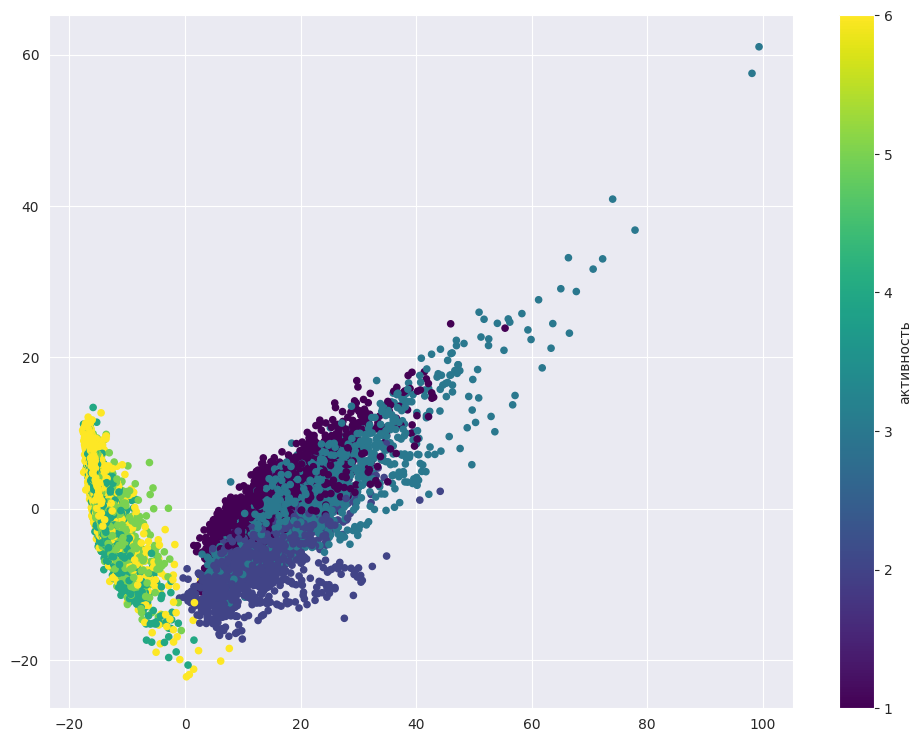

In [26]:
# Ваш код здесь

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
plt.colorbar(label='активность')



**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание) - правильный ответ**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

**ответ: 2**

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [29]:
# Ваш код здесь
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
cluster_labels = kmeans.fit_predict(X_pca)
print('сумма квадратов до центроидов')
kmeans.inertia_

2003454.8999158167

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

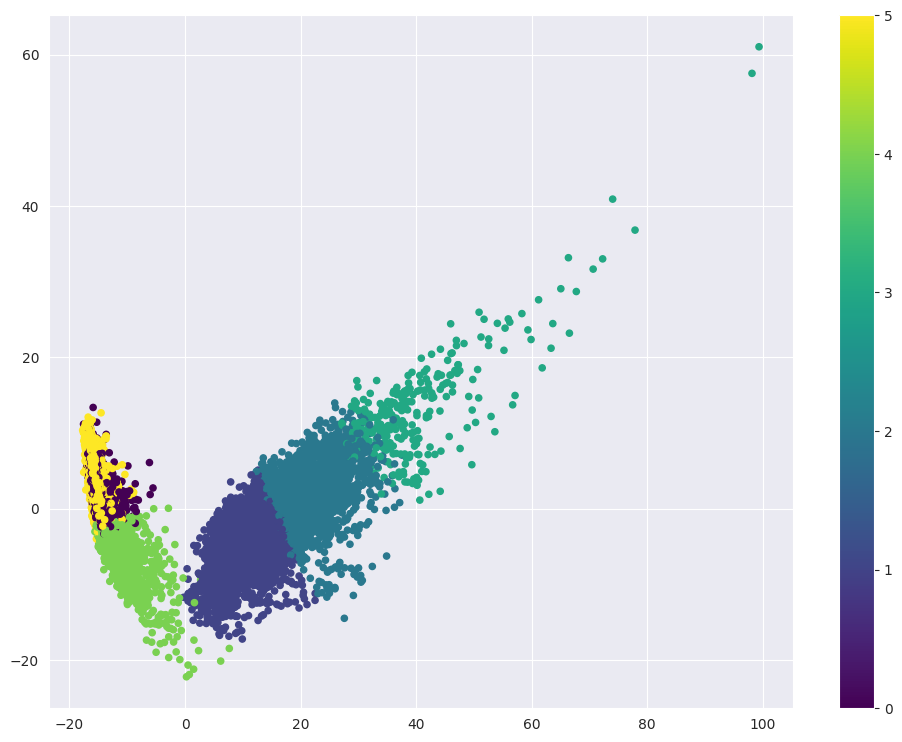

In [31]:
# Ваш код здесь
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20,  cmap='viridis');
plt.colorbar()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [32]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят - правильный ответ**

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [50]:
# Ваш код здесь
from tqdm import tqdm
inertia = []
for k in tqdm(range(1, n_classes + 1)):
    km = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    km.fit(X_pca)
    inertia.append(km.inertia_)

100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


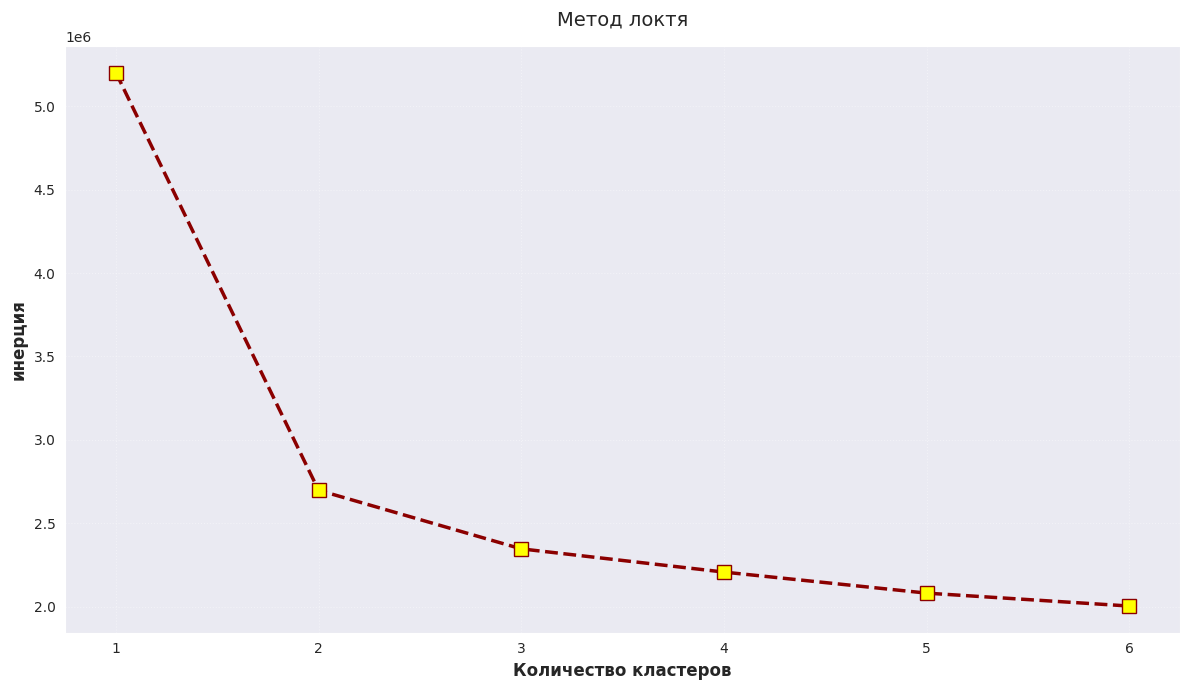

инерция для k от 1 до 6:
  k = 1: 5202757.68
  k = 2: 2697926.76
  k = 3: 2346425.10
  k = 4: 2207131.82
  k = 5: 2080985.11
  k = 6: 2003454.90


In [51]:
plt.figure(figsize=(12, 7))
plt.plot(range(1, n_classes + 1), inertia,
         color='darkred', marker='s', linestyle='--',
         linewidth=2.5, markersize=10, markerfacecolor='yellow')
plt.xlabel('Количество кластеров', fontsize=12, fontweight='bold')
plt.ylabel('инерция', fontsize=12, fontweight='bold')
plt.title('Метод локтя',
          fontsize=14, pad=15)
plt.grid(True, alpha=0.4, linestyle=':')
plt.xticks(range(1, n_classes + 1))
plt.tight_layout()
plt.show()

print(f"инерция для k от 1 до {n_classes}:")
for k, inertia in enumerate(inertia, 1):
    print(f"  k = {k}: {inertia:.2f}")

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2 - правильный ответ**
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [52]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [55]:
# Ваш код здесь
kmeans_ari = metrics.adjusted_rand_score(y, cluster_labels)
ag_ari = metrics.adjusted_rand_score(y, ag.labels_)

print(kmeans_ari, ag_ari)

0.4198070012602345 0.49362763373004886


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**


ответ: все три правильные

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [57]:
# Ваш код здесь
svc_scaler = StandardScaler()
X_train_scaled = svc_scaler.fit_transform(X_train)
X_test_scaled = svc_scaler.transform(X_test)

In [58]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [62]:
# Ваш код здесь

grid_svc = GridSearchCV(
    svc,
    svc_params,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

grid_svc.fit(X_train_scaled, y_train)
best_svc = grid_svc.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [68]:
# Ваш код здесь
print(f"Лучшее значение гиперпараметра C: {grid_svc.best_params_['C']}")
print(f"лучшее качество на кросс-валидации: {grid_svc.best_score_:.4f}")

Лучшее значение гиперпараметра C: 0.1
лучшее качество на кросс-валидации: 0.9381


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1 - правильный ответ**
- 1
- 10

In [64]:
y_predicted = best_svc.predict(X_test_scaled)

In [65]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,427,60,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,443,588,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние - правильный ответ**

In [81]:
dimensionality_reduction = PCA(n_components=0.9, random_state=RANDOM_STATE)

X_train_transformed = dimensionality_reduction.fit_transform(X_train_scaled)
X_test_transformed = dimensionality_reduction.transform(X_test_scaled)

print(f"PCA: {X_train_scaled.shape[1]} --> {X_train_transformed.shape[1]} компонент")

classifier = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)
param_space = {'C': [1e-3, 1e-2, 1e-1, 1, 10]}

optimizer = GridSearchCV(classifier, param_space, cv=3, n_jobs=-1)
optimizer.fit(X_train_transformed, y_train)

print(f"Лучшее C: {optimizer.best_params_['C']}")
print(f"CV accuracy: {optimizer.best_score_:.4f}")


base_performance = grid_svc.best_score_
pca_performance = optimizer.best_score_

reduction_effect = (base_performance - pca_performance) * 100
effect_rounded = round(reduction_effect)

effect_rounded

PCA: 561 --> 63 компонент
Лучшее C: 0.1
CV accuracy: 0.8984


4

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4% - правильный ответ**
- 10%
- 20%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность - правильный ответ**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком - правильный ответ**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

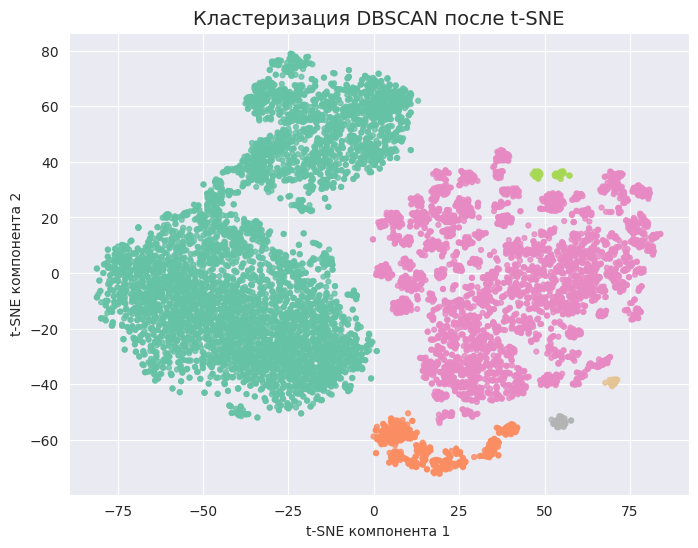

Распределение меток кластеров:
0    5622
1     504
2    4042
3      53
4      24
5      54
Name: count, dtype: int64


In [84]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

pca_preprocessor = PCA(n_components=50, random_state=42)
X_reduced = pca_preprocessor.fit_transform(X_scaled)

tsne_projector = TSNE(n_components=2, random_state=42, perplexity=40, learning_rate='auto', init='random')
X_embedded = tsne_projector.fit_transform(X_reduced)

clusterer = DBSCAN(eps=5, min_samples=10)
cluster_labels = clusterer.fit_predict(X_embedded)

plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cluster_labels, cmap='Set2', s=12, alpha=0.8)
plt.title('Кластеризация DBSCAN после t-SNE', fontsize=14)
plt.xlabel('t-SNE компонента 1')
plt.ylabel('t-SNE компонента 2')
plt.show()

print("Распределение меток кластеров:")
print(pd.Series(cluster_labels).value_counts().sort_index())